In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2
%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
import os
from pathlib import Path
import pickle

home = str(Path.home())
data_path = os.path.join(home, "GA_generation", "Data", "GA_resampled.parquet")
perp_path = os.path.join(home, "GA_generation", "Data", "Normals_sampling.parquet")

import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
from scipy.spatial.distance import cdist

from traffic.core import Traffic, Flight
from traffic.data import airports
from traffic.drawing import countries
import traffic.core.geodesy as geo

t_GA_resampled = Traffic.from_file(data_path)
perpendiculars = pd.read_parquet(perp_path)
perpendiculars["angle"] = np.arctan(perpendiculars.m)

<ipython-input-2-78770095fdcc>:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


<IPython.core.display.Javascript object>

# Features Engineering

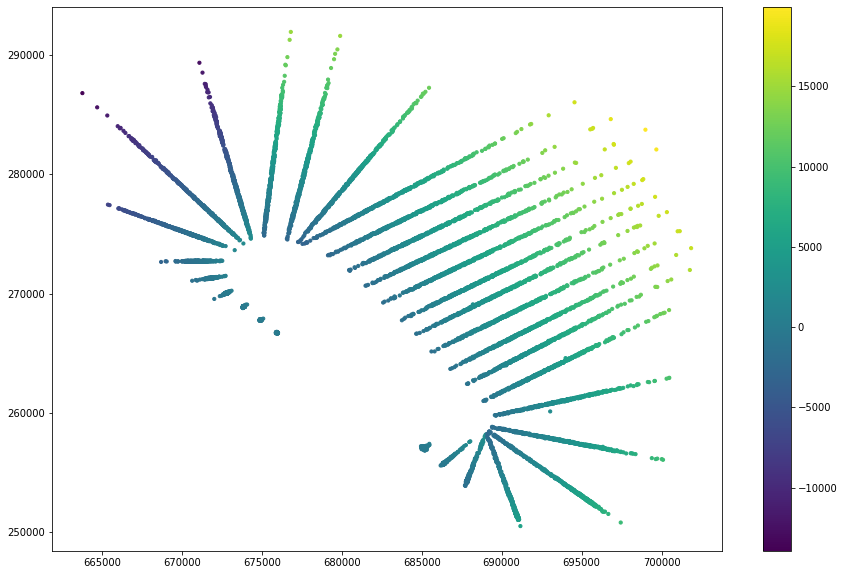

<IPython.core.display.Javascript object>

In [3]:
features = ["x", "y"]
X = np.stack(list(f.data[features].values.ravel() for f in t_GA_resampled))

X_x = X[:, ::2]
X_y = X[:, 1::2]
origins = np.zeros((len(perpendiculars), 2))

origins[:, 0] = perpendiculars.x.values
origins[:, 1] = perpendiculars.y.values

X_along_line = np.cos(perpendiculars.angle.values) * (X_x - origins[:, 0]) + np.sin(
    perpendiculars.angle.values
) * (X_y - origins[:, 1])

X_along_line = pd.DataFrame(X_along_line)

X_along_line.to_pickle(
    os.path.join(Path.home(), "GA_generation", "Data", "distributions_along_lines.pkl")
)

x, y, z = (
    np.array(X[:, ::2]).flatten(),
    np.array(X[:, 1::2]).flatten(),
    np.array(X_along_line).flatten(),
)
cmap = sns.color_palette("viridis", as_cmap=True)
f, ax = plt.subplots(figsize=(15, 10))
points = ax.scatter(x, y, c=z, s=10, cmap=cmap)
f.colorbar(points)
plt.show()

In [4]:
for i in range(0, 29):
    res = sp.stats.kendalltau(X_along_line.loc[i], X_along_line.loc[i + 1])
    if res[1] > 0.005:
        print(i, " and ", i + 1, "cannot be said to be dependant")

3  and  4 cannot be said to be dependant
4  and  5 cannot be said to be dependant
5  and  6 cannot be said to be dependant
14  and  15 cannot be said to be dependant
15  and  16 cannot be said to be dependant
18  and  19 cannot be said to be dependant
21  and  22 cannot be said to be dependant
28  and  29 cannot be said to be dependant


<IPython.core.display.Javascript object>

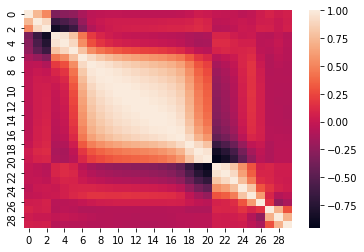

<IPython.core.display.Javascript object>

In [5]:
corrMatrix = X_along_line.corr()
sns.heatmap(corrMatrix)
plt.show()

# Real data

In [6]:
# Signed curvature
def curvature(x, y):
    x_t = np.gradient(x)
    y_t = np.gradient(y)
    xx_t = np.gradient(x_t)
    yy_t = np.gradient(y_t)

    return (xx_t * y_t - x_t * yy_t) / (x_t * x_t + y_t * y_t) ** (3 / 2)

<IPython.core.display.Javascript object>

In [7]:
from scipy.spatial import distance

def energy_distance(x, y):
    n1 = x.shape[0]
    n2 = y.shape[0]
    a = cdist(x, y, "euclidean").mean()
    b = cdist(x, x, "euclidean").mean()
    c = cdist(y, y, "euclidean").mean()
    e = (n1 * n2 / (n1 + n2)) * (2 * a - b - c)
    return e

<IPython.core.display.Javascript object>

In [8]:
from scipy.interpolate import CubicSpline

x = list(range(0, 30))
y = np.vstack((X[:, ::2], X[:, 1::2])).T
cs = CubicSpline(x, y)
xs = np.linspace(0, 29, 1000)

spline_x, spline_y = (
    cs(xs)[:, cs(xs).shape[1] // 2 :],
    cs(xs)[:, : cs(xs).shape[1] // 2],
)

<IPython.core.display.Javascript object>

In [9]:
variations = []
nb_turns = []
for i in range(spline_x.shape[1]):
    indexes1 = np.where(curvature(spline_x[:, i], spline_y[:, i]) > 0.00010)
    indexes2 = np.where(curvature(spline_x[:, i], spline_y[:, i]) < -0.00010)

    variations.append(np.gradient(curvature(spline_x[:, i], spline_y[:, i])))
    nb_turns.append(
        np.sum(np.diff(indexes1[0], 1) != 1)
        + 1
        + np.sum(np.diff(indexes2[0], 1) != 1)
        + 1
    )

print("Variation moyenne : ", np.abs(variations).mean())
print("Mean number of turns : ", np.array(nb_turns).mean())

Variation moyenne :  2.0307706864678356e-05
Mean number of turns :  7.823095823095823


<IPython.core.display.Javascript object>

# Vine + sampling

In [105]:
# En spécifiant la structure de la vine
# matrice pour une D vine
# De toute facon, l'algo estime de lui même une DVine; Autant accélérer les choses

matD = np.zeros((30, 30))
matD[:29, 0] = list(range(2, 31))

for i in range(1, 30):
    matD[:29, i] = matD[:29, i - 1] + 1

matD[matD > 30] = 0

for i in range(0, 30):
    matD[i, 29 - i] = 30 - i

<IPython.core.display.Javascript object>

In [109]:
import openturns as ot
from sklearn import preprocessing
import pyvinecopulib as pv
from scipy.interpolate import CubicSpline

to_fit = np.array(X_along_line)
sample = ot.Sample(to_fit)

u = pv.to_pseudo_obs(sample)  # CDR empirique (c'est mieux)
cop = pv.Vinecop(data=u, matrix=matD)
n_sim = 1000
u_sim = cop.simulate(n_sim)
x_sim = np.asarray(
    [np.quantile(sample[:, i], u_sim[:, i]) for i in range(0, to_fit.shape[1])]
).T

pd.DataFrame(x_sim).to_pickle(
    os.path.join(
        Path.home(), "GA_generation", "Data", "generated_vines_and_sampling.pkl"
    )
)

gen_x = x_sim * np.array([np.cos(perpendiculars.angle.values),] * n_sim) + np.array(
    [origins[:, 0],] * n_sim
)
calc_y = perpendiculars.m.values * gen_x + perpendiculars.p.values

x = list(range(0, to_fit.shape[1]))
y = np.vstack((gen_x, calc_y)).T
cs = CubicSpline(x, y)
xs = np.linspace(0, to_fit.shape[1] - 1, 1000)

spline_x, spline_y = (
    cs(xs)[:, cs(xs).shape[1] // 2 :],
    cs(xs)[:, : cs(xs).shape[1] // 2],
)

<IPython.core.display.Javascript object>

In [110]:
variations = []
nb_turns = []
for i in range(spline_x.shape[1]):
    indexes1 = np.where(curvature(spline_x[:, i], spline_y[:, i]) > 0.00010)
    indexes2 = np.where(curvature(spline_x[:, i], spline_y[:, i]) < -0.00010)

    variations.append(np.gradient(curvature(spline_x[:, i], spline_y[:, i])))
    nb_turns.append(
        np.sum(np.diff(indexes1[0], 1) != 1)
        + 1
        + np.sum(np.diff(indexes2[0], 1) != 1)
        + 1
    )

print("Variation moyenne : ", np.abs(variations).mean())
print("Mean number of turns : ", np.array(nb_turns).mean())
print("Energy distance : ", energy_distance(x_sim, np.array(X_along_line)))

Variation moyenne :  0.00020125862292045483
Mean number of turns :  12.841
Energy distance :  8936.288732091913


<IPython.core.display.Javascript object>

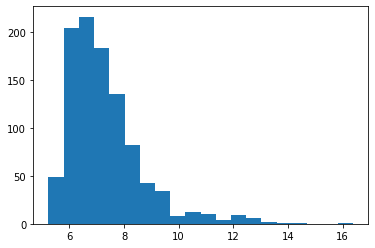

<IPython.core.display.Javascript object>

In [111]:
# Distance moyenne de Mahala de chaque généré par rapport aux réels

plt.hist(cdist(x_sim, np.array(X_along_line), "mahalanobis").mean(axis=1), bins=20)
plt.show()

# MVN with sampling

In [202]:
from sklearn.covariance import LedoitWolf

n_sim = 1000

# When using LedoitWolf for covariance, results are not good at all
cov = LedoitWolf().fit(X_along_line)
x_sim = np.random.multivariate_normal(
    X_along_line.mean(), np.cov(X_along_line.T), n_sim
)

pd.DataFrame(x_sim).to_pickle(
    os.path.join(Path.home(), "GA_generation", "Data", "generated_MVN_and_sampling.pkl")
)

gen_x = x_sim * np.array([np.cos(perpendiculars.angle.values),] * n_sim) + np.array(
    [origins[:, 0],] * n_sim
)
calc_y = perpendiculars.m.values * gen_x + perpendiculars.p.values

x = list(range(0, to_fit.shape[1]))
y = np.vstack((gen_x, calc_y)).T
cs = CubicSpline(x, y)
xs = np.linspace(0, to_fit.shape[1] - 1, 1000)

spline_x, spline_y = (
    cs(xs)[:, cs(xs).shape[1] // 2 :],
    cs(xs)[:, : cs(xs).shape[1] // 2],
)

<IPython.core.display.Javascript object>

In [203]:
variations = []
nb_turns = []
for i in range(spline_x.shape[1]):
    indexes1 = np.where(curvature(spline_x[:, i], spline_y[:, i]) > 0.00010)
    indexes2 = np.where(curvature(spline_x[:, i], spline_y[:, i]) < -0.00010)

    variations.append(np.gradient(curvature(spline_x[:, i], spline_y[:, i])))
    nb_turns.append(
        np.sum(np.diff(indexes1[0], 1) != 1)
        + 1
        + np.sum(np.diff(indexes2[0], 1) != 1)
        + 1
    )

print("Variation moyenne : ", np.abs(variations).mean())
print("Mean number of turns : ", np.array(nb_turns).mean())
print("Energy distance : ", energy_distance(x_sim, np.array(X_along_line)))

Variation moyenne :  2.829206840231083e-05
Mean number of turns :  11.76
Energy distance :  48009.87944355729


<IPython.core.display.Javascript object>

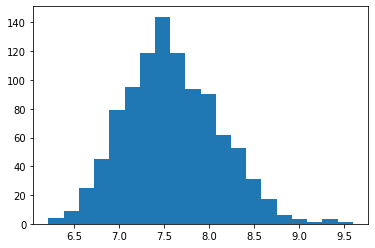

<IPython.core.display.Javascript object>

In [16]:
# Distance moyenne de Mahala de chaque généré par rapport aux réels

plt.hist(cdist(x_sim, np.array(X_along_line), "mahalanobis").mean(axis=1), bins=20)
plt.show()

# Gaussian mixture with sampling

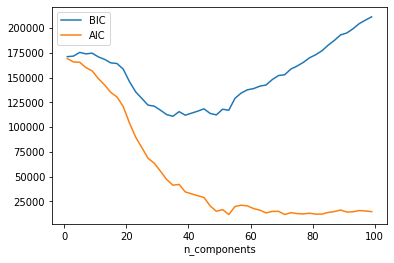

<IPython.core.display.Javascript object>

In [152]:
n_components = np.arange(1, 100, 2)
models = [
    GaussianMixture(n, covariance_type="full", random_state=0).fit(X_along_line)
    for n in n_components
]

plt.plot(n_components, [m.bic(X_along_line) for m in models], label="BIC")
plt.plot(n_components, [m.aic(X_along_line) for m in models], label="AIC")
plt.legend(loc="best")
plt.xlabel("n_components")

In [163]:
from sklearn.mixture import GaussianMixture

n_mixtures = 40
n_sim = 1000
gm = GaussianMixture(n_components=n_mixtures).fit(X_along_line)
x_sim = gm.sample(n_sim)[0]

pd.DataFrame(x_sim).to_pickle(
    os.path.join(Path.home(), "GA_generation", "Data", "generated_GM_and_sampling.pkl")
)

gen_x = x_sim * np.array([np.cos(perpendiculars.angle.values),] * n_sim) + np.array(
    [origins[:, 0],] * n_sim
)
calc_y = perpendiculars.m.values * gen_x + perpendiculars.p.values

x = list(range(0, to_fit.shape[1]))
y = np.vstack((gen_x, calc_y)).T
cs = CubicSpline(x, y)
xs = np.linspace(0, to_fit.shape[1] - 1, 1000)

spline_x, spline_y = (
    cs(xs)[:, cs(xs).shape[1] // 2 :],
    cs(xs)[:, : cs(xs).shape[1] // 2],
)

<IPython.core.display.Javascript object>

In [164]:
variations = []
nb_turns = []
for i in range(spline_x.shape[1]):
    indexes1 = np.where(curvature(spline_x[:, i], spline_y[:, i]) > 0.00010)
    indexes2 = np.where(curvature(spline_x[:, i], spline_y[:, i]) < -0.00010)

    variations.append(np.gradient(curvature(spline_x[:, i], spline_y[:, i])))
    nb_turns.append(
        np.sum(np.diff(indexes1[0], 1) != 1)
        + 1
        + np.sum(np.diff(indexes2[0], 1) != 1)
        + 1
    )

print("Variation moyenne : ", np.abs(variations).mean())
print("Mean number of turns : ", np.array(nb_turns).mean())
print("Energy distance : ", energy_distance(x_sim, np.array(X_along_line)))

Variation moyenne :  1.66062520238804e-05
Mean number of turns :  9.236
Energy distance :  5379.408811328354


<IPython.core.display.Javascript object>

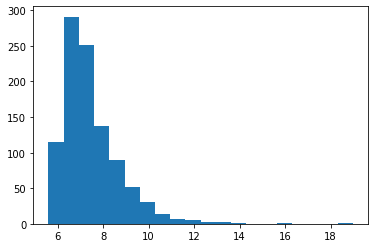

<IPython.core.display.Javascript object>

In [165]:
# Distance moyenne de Mahala de chaque généré par rapport aux réels

plt.hist(cdist(x_sim, np.array(X_along_line), "mahalanobis").mean(axis=1), bins=20)
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

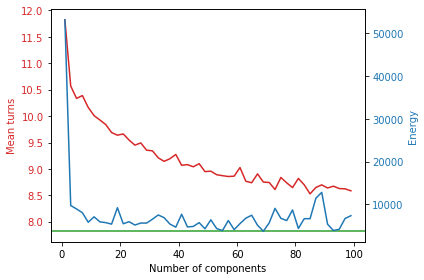

<IPython.core.display.Javascript object>

In [167]:
meansD = []
meansT = []

for i in tqdm(range(1, 100, 2)):
    n_mixtures = i
    n_sim = 1000
    gm = GaussianMixture(n_components=n_mixtures).fit(X_along_line)
    x_sim = gm.sample(n_sim)[0]

    gen_x = x_sim * np.array([np.cos(perpendiculars.angle.values),] * n_sim) + np.array(
        [origins[:, 0],] * n_sim
    )
    calc_y = perpendiculars.m.values * gen_x + perpendiculars.p.values

    x = list(range(0, to_fit.shape[1]))
    y = np.vstack((gen_x, calc_y)).T
    cs = CubicSpline(x, y)
    xs = np.linspace(0, to_fit.shape[1] - 1, 1000)

    spline_x, spline_y = (
        cs(xs)[:, cs(xs).shape[1] // 2 :],
        cs(xs)[:, : cs(xs).shape[1] // 2],
    )

    nb_turns = []
    for i in range(spline_x.shape[1]):
        indexes1 = np.where(curvature(spline_x[:, i], spline_y[:, i]) > 0.00010)
        indexes2 = np.where(curvature(spline_x[:, i], spline_y[:, i]) < -0.00010)

        nb_turns.append(
            np.sum(np.diff(indexes1[0], 1) != 1)
            + 1
            + np.sum(np.diff(indexes2[0], 1) != 1)
            + 1
        )

    #     meansD.append(cdist(x_sim, np.array(X_along_line), "mahalanobis").mean())
    meansD.append(energy_distance(x_sim, np.array(X_along_line)))
    meansT.append(np.abs(nb_turns).mean())


fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("Number of components")
ax1.set_ylabel("Mean turns", color=color)
ax1.plot(range(1, 100, 2), meansT, color=color)
ax1.axhline(7.82, color="tab:green")  # true dataset mean turns
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()

color = "tab:blue"
ax2.set_ylabel("Energy", color=color)
ax2.plot(range(1, 100, 2), meansD, color=color)
ax2.tick_params(axis="y", labelcolor=color)

fig.tight_layout()
plt.show()

# Copulas without sampling

In [21]:
X_raw = pd.read_pickle("Data/X_raw.pkl")

<IPython.core.display.Javascript object>

In [22]:
u = pv.to_pseudo_obs(X_raw)
cop = pv.Vinecop(data=u)
n_sim = 1000
u_sim = cop.simulate(n_sim)
x_sim = np.asarray(
    [np.quantile(X_raw.iloc[:, i], u_sim[:, i]) for i in range(0, 30 * 2)]
).T

pd.DataFrame(x_sim).to_pickle(
    os.path.join(
        Path.home(), "GA_generation", "Data", "generated_vines_without_sampling.pkl"
    )
)

gen_x = x_sim[:, ::2]
gen_y = x_sim[:, 1::2]

x = list(range(0, to_fit.shape[1]))
y = np.vstack((gen_x, gen_y)).T
cs = CubicSpline(x, y)
xs = np.linspace(0, to_fit.shape[1] - 1, 1000)

spline_x, spline_y = (
    cs(xs)[:, cs(xs).shape[1] // 2 :],
    cs(xs)[:, : cs(xs).shape[1] // 2],
)

<IPython.core.display.Javascript object>

In [23]:
variations = []
nb_turns = []
for i in range(spline_x.shape[1]):
    indexes1 = np.where(curvature(spline_x[:, i], spline_y[:, i]) > 0.00010)
    indexes2 = np.where(curvature(spline_x[:, i], spline_y[:, i]) < -0.00010)

    variations.append(np.gradient(curvature(spline_x[:, i], spline_y[:, i])))
    nb_turns.append(
        np.sum(np.diff(indexes1[0], 1) != 1)
        + 1
        + np.sum(np.diff(indexes2[0], 1) != 1)
        + 1
    )

print("Variation moyenne : ", np.abs(variations).mean())
print("Mean number of turns : ", np.array(nb_turns).mean())
print("Energy distance : ", energy_distance(x_sim, np.array(X_raw)))

Variation moyenne :  2.9744965829252104e-05
Mean number of turns :  11.467
Energy distance :  36565.28149000924


<IPython.core.display.Javascript object>

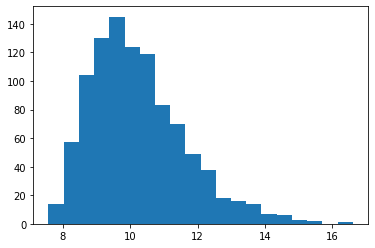

<IPython.core.display.Javascript object>

In [24]:
# Distance moyenne de Mahala de chaque généré par rapport aux réels

plt.hist(cdist(x_sim, np.array(X_raw), "mahalanobis").mean(axis=1), bins=20)
plt.show()

# Gaussian mixture without sampling

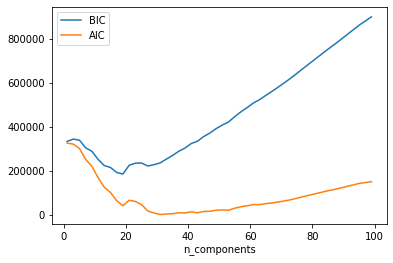

<IPython.core.display.Javascript object>

In [168]:
n_components = np.arange(1, 100, 2)
models = [
    GaussianMixture(n, covariance_type="full", random_state=0).fit(X_raw)
    for n in n_components
]

plt.plot(n_components, [m.bic(X_raw) for m in models], label="BIC")
plt.plot(n_components, [m.aic(X_raw) for m in models], label="AIC")
plt.legend(loc="best")
plt.xlabel("n_components")

In [187]:
n_mixtures = 30
n_sim = 1000
gm = GaussianMixture(n_components=n_mixtures).fit(X_raw)
x_sim = gm.sample(n_sim)[0]


pd.DataFrame(x_sim).to_pickle(
    os.path.join(
        Path.home(), "GA_generation", "Data", "generated_GM_without_sampling.pkl"
    )
)

gen_x = x_sim[:, ::2]
gen_y = x_sim[:, 1::2]

x = list(range(0, to_fit.shape[1]))
y = np.vstack((gen_x, gen_y)).T
cs = CubicSpline(x, y)
xs = np.linspace(0, to_fit.shape[1] - 1, 1000)

spline_x, spline_y = (
    cs(xs)[:, cs(xs).shape[1] // 2 :],
    cs(xs)[:, : cs(xs).shape[1] // 2],
)

<IPython.core.display.Javascript object>

In [188]:
variations = []
nb_turns = []
for i in range(spline_x.shape[1]):
    indexes1 = np.where(curvature(spline_x[:, i], spline_y[:, i]) > 0.00010)
    indexes2 = np.where(curvature(spline_x[:, i], spline_y[:, i]) < -0.00010)

    variations.append(np.gradient(curvature(spline_x[:, i], spline_y[:, i])))
    nb_turns.append(
        np.sum(np.diff(indexes1[0], 1) != 1)
        + 1
        + np.sum(np.diff(indexes2[0], 1) != 1)
        + 1
    )

print("Variation moyenne : ", np.abs(variations).mean())
print("Mean number of turns : ", np.array(nb_turns).mean())
print("Energy distance : ", energy_distance(x_sim, np.array(X_raw)))

Variation moyenne :  5.552616577696137e-06
Mean number of turns :  7.336
Energy distance :  9208.959841909287


<IPython.core.display.Javascript object>

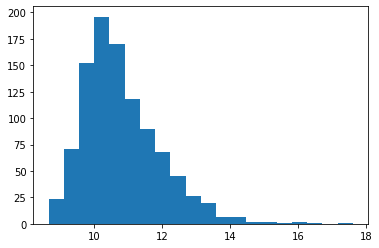

<IPython.core.display.Javascript object>

In [57]:
# Distance moyenne de Mahala de chaque généré par rapport aux réels

plt.hist(cdist(x_sim, np.array(X_raw), "mahalanobis").mean(axis=1), bins=20)
plt.show()

  0%|          | 0/40 [00:00<?, ?it/s]

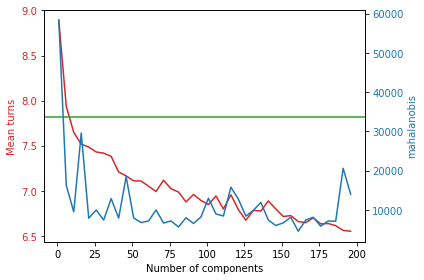

<IPython.core.display.Javascript object>

In [28]:
meansD = []
meansT = []

for i in tqdm(range(1, 200, 5)):
    n_mixtures = i
    n_sim = 1000
    gm = GaussianMixture(n_components=n_mixtures).fit(X_raw)
    x_sim = gm.sample(n_sim)[0]

    gen_x = x_sim[:, ::2]
    gen_y = x_sim[:, 1::2]

    x = list(range(0, to_fit.shape[1]))
    y = np.vstack((gen_x, gen_y)).T
    cs = CubicSpline(x, y)
    xs = np.linspace(0, to_fit.shape[1] - 1, 1000)

    spline_x, spline_y = (
        cs(xs)[:, cs(xs).shape[1] // 2 :],
        cs(xs)[:, : cs(xs).shape[1] // 2],
    )

    nb_turns = []
    for i in range(spline_x.shape[1]):
        indexes1 = np.where(curvature(spline_x[:, i], spline_y[:, i]) > 0.00010)
        indexes2 = np.where(curvature(spline_x[:, i], spline_y[:, i]) < -0.00010)

        nb_turns.append(
            np.sum(np.diff(indexes1[0], 1) != 1)
            + 1
            + np.sum(np.diff(indexes2[0], 1) != 1)
            + 1
        )

    #     meansD.append(cdist(x_sim, np.array(X_raw), "mahalanobis").mean())
    meansD.append(energy_distance(x_sim, np.array(X_raw)))
    meansT.append(np.abs(nb_turns).mean())


fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("Number of components")
ax1.set_ylabel("Mean turns", color=color)
ax1.plot(range(1, 200, 5), meansT, color=color)
ax1.axhline(7.82, color="tab:green")
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = "tab:blue"
ax2.set_ylabel("mahalanobis", color=color)  # we already handled the x-label with ax1
ax2.plot(range(1, 200, 5), meansD, color=color)
ax2.tick_params(axis="y", labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# MVN without sampling

In [29]:
n_gen = 1000
cov = LedoitWolf().fit(X_raw)
x_sim = np.random.multivariate_normal(cov.location_, np.cov(X_raw.T), n_gen)


pd.DataFrame(x_sim).to_pickle(
    os.path.join(
        Path.home(), "GA_generation", "Data", "generated_MVN_without_sampling.pkl"
    )
)

gen_x = x_sim[:, ::2]
gen_y = x_sim[:, 1::2]

x = list(range(0, to_fit.shape[1]))
y = np.vstack((gen_x, gen_y)).T
cs = CubicSpline(x, y)
xs = np.linspace(0, to_fit.shape[1] - 1, 1000)

spline_x, spline_y = (
    cs(xs)[:, cs(xs).shape[1] // 2 :],
    cs(xs)[:, : cs(xs).shape[1] // 2],
)

<IPython.core.display.Javascript object>

In [30]:
variations = []
nb_turns = []
for i in range(spline_x.shape[1]):
    indexes1 = np.where(curvature(spline_x[:, i], spline_y[:, i]) > 0.00010)
    indexes2 = np.where(curvature(spline_x[:, i], spline_y[:, i]) < -0.00010)

    variations.append(np.gradient(curvature(spline_x[:, i], spline_y[:, i])))
    nb_turns.append(
        np.sum(np.diff(indexes1[0], 1) != 1)
        + 1
        + np.sum(np.diff(indexes2[0], 1) != 1)
        + 1
    )

print("Variation moyenne : ", np.abs(variations).mean())
print("Mean number of turns : ", np.array(nb_turns).mean())
print("Energy distance : ", energy_distance(x_sim, np.array(X_raw)))

Variation moyenne :  5.903780600065714e-06
Mean number of turns :  8.86
Energy distance :  53731.40587115893


<IPython.core.display.Javascript object>

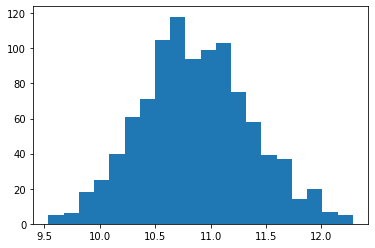

<IPython.core.display.Javascript object>

In [31]:
# Distance moyenne de Mahala de chaque généré par rapport aux réels

plt.hist(cdist(x_sim, np.array(X_raw), "mahalanobis").mean(axis=1), bins=20)
plt.show()